Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[INFO] Training images: 320


  0%|          | 0/320 [00:00<?, ?it/s]

[INFO] Data matrix shape: (10304, 320)
[INFO] Saved mean_face, eigenfaces_Q, W_train → /content/drive/MyDrive/eigenfaces_artifacts


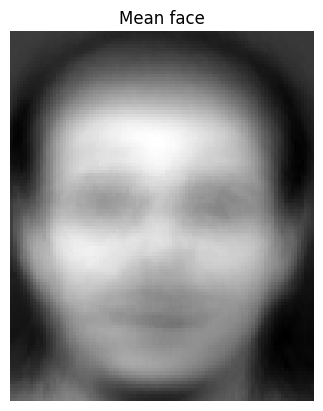

In [5]:
# ================================================================
# 0.  Mount Drive & edit paths  ── change only these three lines ──
# ================================================================
from google.colab import drive
drive.mount('/content/drive')

MANIFEST = "/content/drive/MyDrive/split_manifest_intra.csv"   # CSV
IMG_ROOT = "/content/drive/MyDrive/faces_dataset"              # s1/, s2/, …
SAVE_DIR = "/content/drive/MyDrive/eigenfaces_artifacts"       # outputs

# ================================================================
# 1.  Imports & hyper-parameters
# ================================================================
import os, cv2, numpy as np, pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

IMG_SHAPE = (112, 92)   # ORL resolution
K_EIGEN   = 10          # exactly 10 eigenfaces

os.makedirs(SAVE_DIR, exist_ok=True)

# ================================================================
# 2.  Helper functions
# ================================================================
def safe_relpath(p: str) -> str:
    """Strip IMG_ROOT / leading slash → relative path like 's1/1.pgm'."""
    p = str(p).strip()
    if os.path.isabs(p):
        p = os.path.relpath(p, IMG_ROOT)
    return p.lstrip('/')

def build_rel_path(row) -> str:
    img = safe_relpath(row.get('image', ''))
    folder = str(row.get('folder', '')).strip('/ ')
    if folder and not img.startswith(folder + '/'):
        img = f"{folder}/{img}" if img else folder
    return img

def load_image(rel_path):
    abs_path = os.path.join(IMG_ROOT, rel_path)   # rel_path already clean
    I = cv2.imread(abs_path, cv2.IMREAD_GRAYSCALE)
    if I is None:
        raise FileNotFoundError(abs_path)
    if I.shape != IMG_SHAPE:
        I = cv2.resize(I, IMG_SHAPE[::-1])
    return I.reshape(-1).astype(np.float32)       # (NM,)

def svd_eigenfaces(V, k=K_EIGEN):
    K = V.shape[1]
    X = V / np.sqrt(K)
    _, S, VT = np.linalg.svd(X.T, full_matrices=False)
    Q = VT.T[:, :k]                               # (NM×k)
    assert np.allclose(Q.T @ Q, np.eye(k), atol=1e-4)
    return Q

# ================================================================
# 3.  Read manifest & keep only the training split
# ================================================================
df = pd.read_csv(MANIFEST)

# build or clean the 'path' column
if 'path' not in df.columns:
    if 'image' in df.columns:
        df['path'] = df.apply(build_rel_path, axis=1)
    else:
        raise ValueError("CSV needs 'path' or at least 'image' column")
df['path'] = df['path'].apply(safe_relpath)

df_train = df[df['split'] == 'train'].reset_index(drop=True)
print(f"[INFO] Training images: {len(df_train)}")

# ================================================================
# 4.  Build the training data matrix C_train (NM × K)
# ================================================================
cols = []
for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
    cols.append(load_image(row['path']))
C_train = np.stack(cols, axis=1)                 # (NM, K)
print("[INFO] Data matrix shape:", C_train.shape)

# ================================================================
# 5.  Eigenfaces training (Question 2)
# ================================================================
c_m     = C_train.mean(axis=1, keepdims=True)    # mean face
V       = C_train - c_m                          # centred data
Q       = svd_eigenfaces(V)                      # eigenfaces (NM×10)
W_train = Q.T @ V                                # weights (10×K)

# ================================================================
# 6.  Save artefacts for later tasks
# ================================================================
np.save(f"{SAVE_DIR}/mean_face.npy",    c_m)
np.save(f"{SAVE_DIR}/eigenfaces_Q.npy", Q)
np.save(f"{SAVE_DIR}/W_train.npy",      W_train)
print(f"[INFO] Saved mean_face, eigenfaces_Q, W_train → {SAVE_DIR}")

# optional preview
plt.imshow(c_m.reshape(IMG_SHAPE), cmap='gray')
plt.title("Mean face"); plt.axis('off'); plt.show()


In [10]:
# ================================================================
# 0.  Mount Drive & path settings  ── EDIT THESE THREE LINES ─────
# ================================================================
from google.colab import drive
drive.mount('/content/drive')

MANIFEST = "/content/drive/MyDrive/split_manifest_intra.csv"   # CSV
IMG_ROOT = "/content/drive/MyDrive/faces_dataset"              # images
ART_DIR  = "/content/drive/MyDrive/eigenfaces_artifacts"       # Q2 outputs
OUT_CSV  = "/content/drive/MyDrive/eval_predictions.csv"       # Result file

# ================================================================
# 1.  Imports & constants
# ================================================================
import os, cv2, numpy as np, pandas as pd
from tqdm.auto import tqdm

IMG_SHAPE  = (112, 92)
K_EIGEN    = 10                    # must match training
P_NORM     = 2                     # ℓ₂ distance

# ================================================================
# 2.  Helper functions
# ================================================================
def clean_rel(p: str) -> str:
    p = str(p).strip()
    if os.path.isabs(p) and p.startswith(IMG_ROOT):
        p = p[len(IMG_ROOT):]
    return p.lstrip('/')

def build_rel_path(row) -> str:
    img = clean_rel(row.get('image', ''))
    folder = str(row.get('folder', '')).strip('/')
    if folder and not img.startswith(folder + '/'):
        img = f"{folder}/{img}" if img else folder
    return img

def load_img(rel_path):
    abs_path = os.path.join(IMG_ROOT, rel_path)
    I = cv2.imread(abs_path, cv2.IMREAD_GRAYSCALE)
    if I is None:
        raise FileNotFoundError(abs_path)
    if I.shape != IMG_SHAPE:
        I = cv2.resize(I, IMG_SHAPE[::-1])
    return I.reshape(-1).astype(np.float32)

# ================================================================
# 3.  Load artefacts from Question 2
# ================================================================
c_m     = np.load(f"{ART_DIR}/mean_face.npy")        # (NM,1)
Q       = np.load(f"{ART_DIR}/eigenfaces_Q.npy")     # (NM,k)
W_train = np.load(f"{ART_DIR}/W_train.npy")          # (k, K_train)

# ================================================================
# 4.  Prepare manifest & split
# ================================================================
df = pd.read_csv(MANIFEST)

if 'path' not in df.columns:
    if 'image' in df.columns:
        df['path'] = df.apply(build_rel_path, axis=1)
    else:
        raise ValueError("Manifest needs 'path' or at least 'image' column")
else:
    df['path'] = df['path'].apply(clean_rel)

df_train = df[df['split'] == 'train'].reset_index(drop=True)
df_eval  = df[df['split'] == 'eval'] .reset_index(drop=True)

get_subj = lambda r: r['folder'] if 'folder' in r else r['path'].split('/')[0]
train_labels = df_train.apply(get_subj, axis=1).to_numpy()
eval_subjects = df_eval.apply(get_subj, axis=1).to_numpy()

# ================================================================
# 5.  Project evaluation images & predict subjects
# ================================================================
W_test = []
for p in tqdm(df_eval['path'], desc="Projecting"):
    w = Q.T @ (load_img(p).reshape(-1,1) - c_m)
    W_test.append(w.ravel())
W_test = np.stack(W_test, axis=1)                    # (k, K_eval)

dists = np.linalg.norm(W_train[:, :, None] - W_test[:, None, :],
                       ord=P_NORM, axis=0)           # (K_train, K_eval)
pred_subjects = train_labels[np.argmin(dists, axis=0)]

# ================================================================
# 6.  Save predictions to CSV
# ================================================================
pd.DataFrame({
    "path": df_eval['path'],
    "true_subject": eval_subjects,
    "predicted_subject": pred_subjects
}).to_csv(OUT_CSV, index=False)

print(f"[INFO] Predictions written to {OUT_CSV}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Projecting:   0%|          | 0/80 [00:00<?, ?it/s]

[INFO] Predictions written to /content/drive/MyDrive/eval_predictions.csv


In [13]:
# ================================================================
# 9.  Question 4 – per-subject sensitivity & specificity
# ================================================================
import pandas as pd
from sklearn.metrics import confusion_matrix

subjects = sorted(np.unique(true_labels))
cm = confusion_matrix(true_labels, pred_labels, labels=subjects)   # rows: true, cols: pred

sensitivities = {}   # recall  = TP / (TP+FN)
specificities = {}   #        = TN / (TN+FP)

for i, s in enumerate(subjects):
    TP = cm[i, i]
    FN = cm[i, :].sum() - TP
    FP = cm[:, i].sum() - TP
    TN = cm.sum() - (TP + FN + FP)
    sensitivities[s] = TP / (TP + FN) if (TP + FN) else 0.0
    specificities[s] = TN / (TN + FP) if (TN + FP) else 0.0

metrics_df = pd.DataFrame({
    "sensitivity": pd.Series(sensitivities),
    "specificity": pd.Series(specificities)
}).round(3)

print("\n=== Question 4: sensitivity & specificity per subject ===")
display(metrics_df)          # in Colab this shows nicely; use print() if local
metrics_df.to_csv(f"{ART_DIR}/q4_metrics.csv")
print(f"\n[INFO] table saved to {ART_DIR}/q4_metrics.csv")



=== Question 4: sensitivity & specificity per subject ===


,sensitivity,specificity
s1,1.0,1.000
s10,0.0,1.000
s11,1.0,0.987
s12,1.0,1.000
s13,1.0,1.000
s14,1.0,1.000
s15,1.0,1.000
s16,1.0,1.000
s17,1.0,1.000
s18,1.0,0.987



[INFO] table saved to /content/drive/MyDrive/eigenfaces_artifacts/q4_metrics.csv
